<font size="7">MODEL TRAINING</font>

In [ ]:
import pandas as pd
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import joblib

RANDOM_STATE = 42
N_SPLITS = 5

In [ ]:
ARTIFACTS = Path("artifacts")

df = pd.read_csv("data/processed/df_train_eng.csv")

print("Train shape:", df.shape)
df.head()

Train shape: (16209, 36)


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,is_renovated
0,1000102,280000,6,3.00,2400,9373,2.0,0,0,3,...,False,False,False,False,False,True,False,False,False,0
1,1200019,647500,4,1.75,2060,26036,1.0,0,0,4,...,False,True,False,False,False,False,False,False,False,0
2,1200021,400000,3,1.00,1460,43000,1.0,0,0,3,...,False,False,False,False,True,False,False,False,False,0
3,2800031,235000,3,1.00,1430,7599,1.5,0,0,4,...,True,False,False,False,False,False,False,False,False,0
4,3600057,402500,4,2.00,1650,3504,1.0,0,0,3,...,False,False,False,False,False,False,False,False,False,1


In [ ]:
y = df["price"].values

X_tab = df.drop(columns=["price", "id"])

print("Tabular feature count:", X_tab.shape[1])

Tabular feature count: 34


In [19]:
models = {
    "LinearRegression": LinearRegression(),

    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),

    "XGBoost": XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE
    ),

    "LightGBM": LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        random_state=RANDOM_STATE
    ),
}

In [20]:
def evaluate_model(model, X, y):
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    rmse = -cross_val_score(
        model, X, y,
        scoring="neg_root_mean_squared_error",
        cv=kf
    )

    r2 = cross_val_score(
        model, X, y,
        scoring="r2",
        cv=kf
    )

    return rmse.mean(), r2.mean()

In [21]:
tabular_results = []

for name, model in models.items():
    print(f"Training TABULAR model: {name}")

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    rmse, r2 = evaluate_model(pipe, X_tab, y)

    tabular_results.append({
        "model": name,
        "rmse": rmse,
        "r2": r2
    })

df_tabular_results = pd.DataFrame(tabular_results).sort_values("rmse")
display(df_tabular_results)

Training TABULAR model: LinearRegression
Training TABULAR model: RandomForest
Training TABULAR model: XGBoost
Training TABULAR model: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3123
[LightGBM] [Info] Number of data points in the train set: 12967, number of used features: 34
[LightGBM] [Info] Start training from score 535896.328989
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3155
[LightGBM] [Info] Number of data points in the train set: 12967, number of used features: 34
[LightGBM] [Info] Start training from score 535994.014653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001560 seconds.
You can set `force_row_wise=true` to remove the overhead.
A

,model,rmse,r2
2,XGBoost,116264.548437,0.893504
3,LightGBM,116445.253816,0.893929
1,RandomForest,123869.468749,0.879909
0,LinearRegression,165739.920807,0.786977


In [ ]:
img_feats = pd.read_csv(ARTIFACTS / "image_features_resnet.csv")

print("Image features shape:", img_feats.shape)

df_multi = df.merge(img_feats, on="id", how="inner")

print("Merged shape:", df_multi.shape)

Image features shape: (16209, 513)
Merged shape: (16407, 548)


In [23]:
y_multi = df_multi["price"].values
X_multi = df_multi.drop(columns=["price", "id"])

print("Multimodal feature count:", X_multi.shape[1])

Multimodal feature count: 546


In [24]:
multimodal_results = []

for name, model in models.items():
    if(name == "RandomForest"):
        continue
    print(f"Training MULTIMODAL model: {name}")

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    rmse, r2 = evaluate_model(pipe, X_multi, y_multi)

    multimodal_results.append({
        "model": name,
        "rmse": rmse,
        "r2": r2
    })

df_multimodal_results = pd.DataFrame(multimodal_results).sort_values("rmse")
display(df_multimodal_results)

Training MULTIMODAL model: LinearRegression
Training MULTIMODAL model: XGBoost
Training MULTIMODAL model: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133717
[LightGBM] [Info] Number of data points in the train set: 13125, number of used features: 546
[LightGBM] [Info] Start training from score 536996.292800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133687
[LightGBM] [Info] Number of data points in the train set: 13125, number of used features: 546
[LightGBM] [Info] Start training from score 535704.287619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total

,model,rmse,r2
1,XGBoost,121177.682813,0.886621
2,LightGBM,121791.696844,0.885310
0,LinearRegression,163944.367549,0.792565


In [25]:
comparison = df_tabular_results.merge(
    df_multimodal_results,
    on="model",
    suffixes=("_tabular", "_multimodal")
).sort_values("rmse_multimodal")

display(comparison)

,model,rmse_tabular,r2_tabular,rmse_multimodal,r2_multimodal
0,XGBoost,116264.548437,0.893504,121177.682813,0.886621
1,LightGBM,116445.253816,0.893929,121791.696844,0.885310
2,LinearRegression,165739.920807,0.786977,163944.367549,0.792565


In [26]:
best_model_name = comparison.iloc[0]["model"]
print("Best overall model:", best_model_name)

best_model = models[best_model_name]

final_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", best_model)
])

final_pipeline.fit(X_multi, y_multi)

joblib.dump(final_pipeline, ARTIFACTS / "best_model.pkl")
print("Saved best model to artifacts/best_model.pkl")

Best overall model: XGBoost
Saved best model to artifacts/best_model.pkl


Total Image Feature Contribution: 56.16%


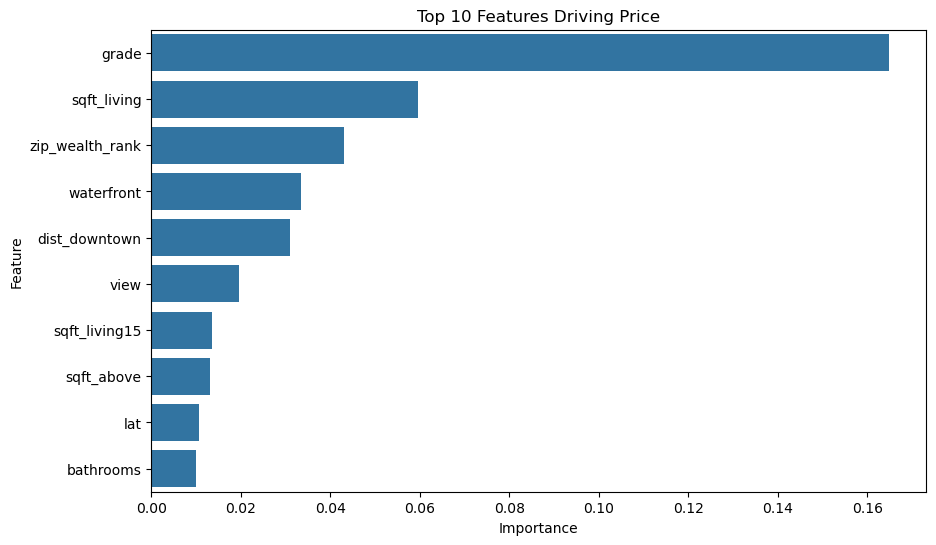

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

importance = pd.DataFrame({
    'Feature': X_multi.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)


img_importance = importance[importance['Feature'].str.contains('img_')]['Importance'].sum()
print(f"Total Image Feature Contribution: {img_importance:.2%}")


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance.head(10))
plt.title("Top 10 Features Driving Price")
plt.show()

In [30]:
joblib.dump(final_pipeline, "artifacts/house_price_model.pkl")

feature_names = X_multi.columns.tolist()
joblib.dump(feature_names, "artifacts/feature_names.pkl")

raw_df = pd.read_csv("train(1)(train(1)).csv") 

zip_wealth_map = raw_df.groupby('zipcode')['price'].mean().to_dict()
joblib.dump(zip_wealth_map, "artifacts/zip_wealth_map.pkl")

print("All artifacts saved successfully!")

All artifacts saved successfully!
